# Importing Libraries

In [1]:
import torch
import torchtext
torch.cuda.is_available()
import tqdm

C:\Users\Raj\anaconda3\envs\Deep-Learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pickle
from wordcloud import WordCloud
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe
import torchtext
import random
import torch.nn.functional as F
import os
import csv
import torchtext.legacy.data as data
import tqdm

# Creating Dataset

In [96]:
Vocab_Size = 10000 
lr = 0.001
Batch_Size = 32
Num_epochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [114]:
dataset_file =r'C:\Users\Raj\Desktop\Deep Learning\Assignment 2\aclImdb_v1\aclImdb\dataset_new.csv'
df = pd.read_csv(dataset_file)
df.head()
summary = df.describe()
print(summary)

          sentiment
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


# Plotting Statistics of dataset

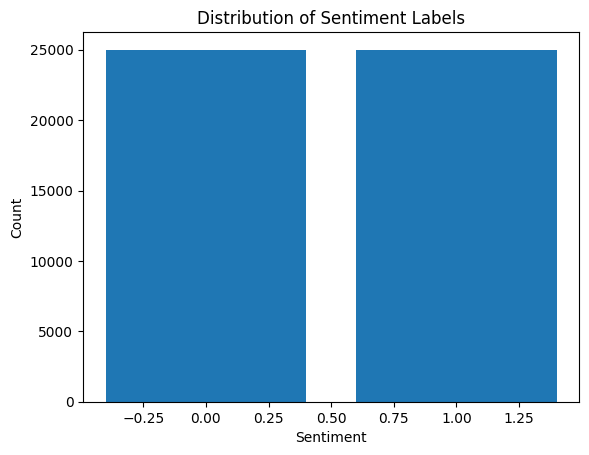

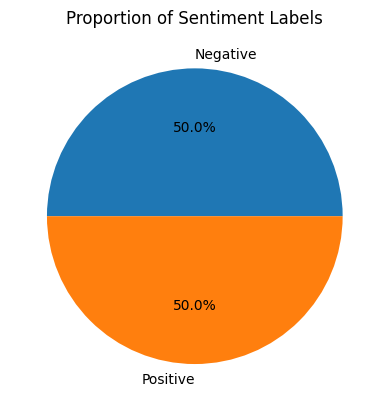

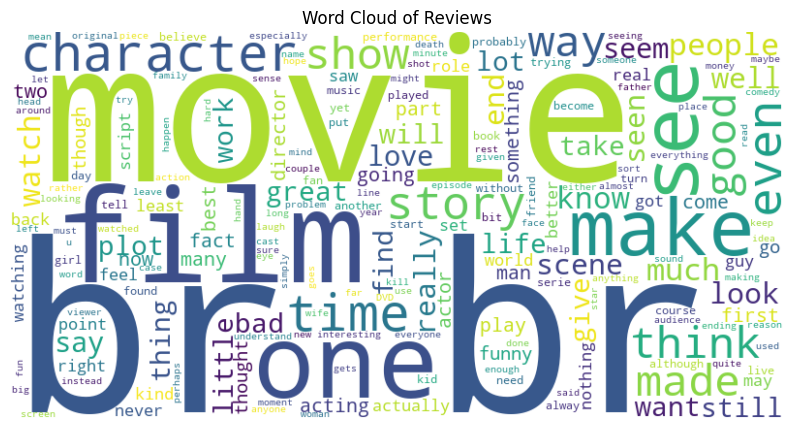

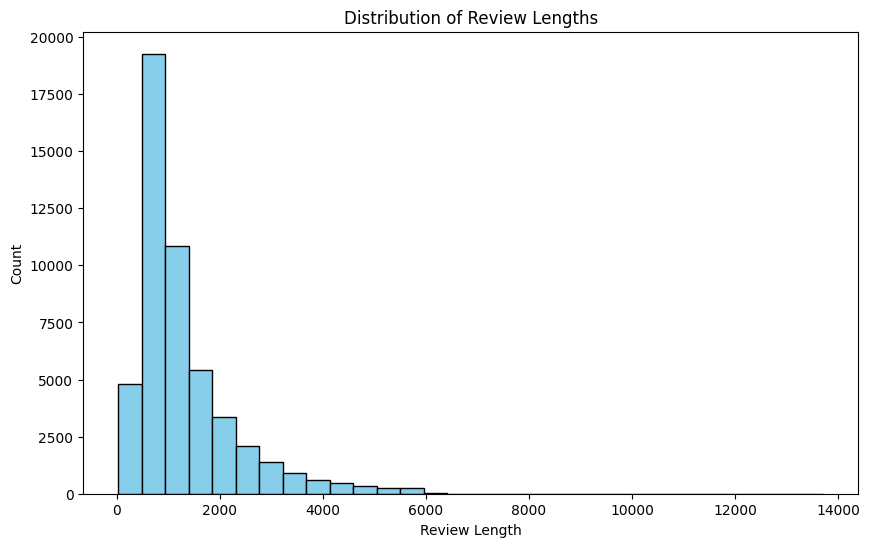

In [86]:
# Bar chart
sentiment_counts = df['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

# Pie chart
sentiment_labels = ['Negative', 'Positive']
sentiment_sizes = df['sentiment'].value_counts().values
plt.pie(sentiment_sizes, labels=sentiment_labels, autopct='%1.1f%%')
plt.title('Proportion of Sentiment Labels')
plt.show()

reviews = ' '.join(df['reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()
df['review_length'] = df['reviews'].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Distribution of Review Lengths')
plt.show()

# Embedding sentiments and creating vocabulary

In [87]:
Text = data.Field(tokenize = 'spacy',tokenizer_language ='en_core_web_sm')
Label = data.LabelField(dtype = torch.long)

In [88]:
fields =[('reviews',Text),('sentiment',Label)]
dataset = data.TabularDataset(path = r'C:\Users\Raj\Desktop\Deep Learning\Assignment 2\aclImdb_v1\aclImdb\dataset_new.csv', format = 'csv',skip_header =True,fields = fields)
train_dataset, test_dataset = dataset.split(split_ratio=[0.7,0.2])
print(f"Training Dataset: {len(train_dataset)}")
print(f"Test Dataset: {len(test_dataset)}")

Training Dataset: 38889
Test Dataset: 11111


In [89]:
Text.build_vocab(train_dataset, max_size = Vocab_Size , min_freq = 5)
Label.build_vocab(train_dataset, min_freq = 5)
print(vars(Label.vocab))
print(f"Size of vocabulary: {len(Text.vocab)}")
print(f"Size of Labels: {len(Label.vocab)}")

{'freqs': Counter({'0': 19449, '1': 19440}), 'itos': ['0', '1'], 'unk_index': None, 'stoi': defaultdict(None, {'0': 0, '1': 1}), 'vectors': None}
Size of vocabulary: 10002
Size of Labels: 2


# Splitting Dataset in training and testing

In [98]:
train_loader, test_loader = torchtext.legacy.data.BucketIterator.splits((train_dataset,test_dataset),batch_size = Batch_Size,sort_within_batch = False,sort_key = lambda x:len(x.reviews),device = device)

# LSTM model

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, emb_size, hidden_size, n_layers, dropout):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        output = self.fc(output[-1])
        return output


In [17]:
Input_Size = len(Text.vocab)
Output_Size = len(Label.vocab)
Hidden_Size = 128
Embedding_Size = 100
Num_Layers = 3
Droput = 0.5
modelLSTM = LSTM(Input_Size, Output_Size,Embedding_Size,Hidden_Size,Num_Layers, Droput).to(device)

In [18]:
modelLSTM.to(device)
print(modelLSTM)
print(len(train_loader))
print(device)

LSTM(
  (embedding): Embedding(10002, 100)
  (lstm): LSTM(100, 128, num_layers=3, dropout=0.5)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
608
cuda:0


In [19]:
optimizer = torch.optim.Adam(modelLSTM.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# LSTM training

In [22]:
train_losses_LSTM = []
for epoch in range(Num_epochs):
    print(f'Epoch: {epoch}')
    modelLSTM.train()
    epoch_loss = 0.0
    total_batches = len(train_loader)
    for i, batch_data in enumerate(train_loader):
        text = batch_data.reviews.to(device)
        labels = batch_data.sentiment.to(device)
        optimizer.zero_grad()
        outputs = modelLSTM(text)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses_LSTM.append(loss.item())
        epoch_loss += loss.item()
        if not i % 50:
            print(f'Epoch: {epoch+1:03d}/{Num_epochs:03d} |'
                  f'Batch {i:03d}/{len(train_loader):03d} |'
                  f'Loss: {loss:.4f}')
    average_loss = epoch_loss / total_batches
    print(f"Epoch: {epoch+1}, Average Training Loss: {average_loss:.4f}") 

Epoch: 0
Epoch: 001/020 |Batch 000/608 |Loss: 0.6864
Epoch: 001/020 |Batch 050/608 |Loss: 0.6931
Epoch: 001/020 |Batch 100/608 |Loss: 0.6898
Epoch: 001/020 |Batch 150/608 |Loss: 0.6995
Epoch: 001/020 |Batch 200/608 |Loss: 0.6964
Epoch: 001/020 |Batch 250/608 |Loss: 0.6845
Epoch: 001/020 |Batch 300/608 |Loss: 0.6927
Epoch: 001/020 |Batch 350/608 |Loss: 0.6958
Epoch: 001/020 |Batch 400/608 |Loss: 0.6938
Epoch: 001/020 |Batch 450/608 |Loss: 0.6934
Epoch: 001/020 |Batch 500/608 |Loss: 0.6865
Epoch: 001/020 |Batch 550/608 |Loss: 0.6892
Epoch: 001/020 |Batch 600/608 |Loss: 0.7053
Epoch: 1, Average Training Loss: 0.6921
Epoch: 1
Epoch: 002/020 |Batch 000/608 |Loss: 0.6969
Epoch: 002/020 |Batch 050/608 |Loss: 0.7025
Epoch: 002/020 |Batch 100/608 |Loss: 0.6866
Epoch: 002/020 |Batch 150/608 |Loss: 0.6913
Epoch: 002/020 |Batch 200/608 |Loss: 0.6954
Epoch: 002/020 |Batch 250/608 |Loss: 0.6932
Epoch: 002/020 |Batch 300/608 |Loss: 0.6850
Epoch: 002/020 |Batch 350/608 |Loss: 0.6892
Epoch: 002/020 |Ba

In [34]:
print(len(train_losses_LSTM))
LSTM_train_loss =[0.6921,0.6916,0.6912,0.6907,0.6900,0.6912,0.6896,0.6883,0.6535,0.6454,0.6606,0.6364,0.5919,0.5404,0.5792, 0.6730,0.6347,0.4800,0.4443,0.4086]
print(len(LSTM_train_loss))
epochs_ = list(range(0,20))
print(epochs_)

12160
20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


# Training loss plot for LSTM

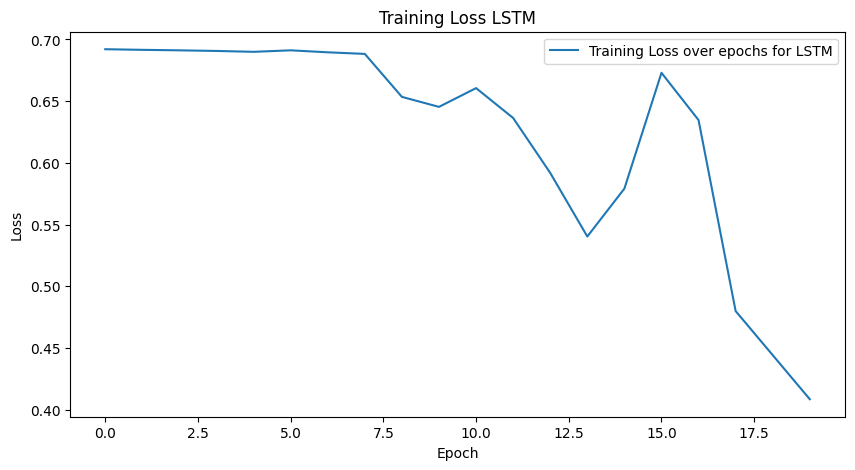

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_,LSTM_train_loss, label = 'Training Loss over epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss LSTM')
plt.legend()
plt.show()

# Evaluating LSTM model 

In [109]:
modelLSTM.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = modelLSTM(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    test_accuracy_LSTM = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy_LSTM:.2f}%")
model_path = r'C:\Users\Raj\Desktop\Deep Learning\Assignment 2\part3\models\rkhatik_assignment2_part3LSTM.pickle'
with open(model_path, 'wb') as file:
    pickle.dump(modelLSTM, file)
print("Model saved successfully.")

Test Accuracy: 79.53%
Model saved successfully.


# GRU model

In [92]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, emb_size, hidden_size, n_layers, dropout):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        output = self.fc(output[-1])
        return output

In [93]:
Input_Size = len(Text.vocab)
Output_Size = len(Label.vocab)
Hidden_Size = 128
Embedding_Size = 100
Num_Layers = 3
Droput = 0.5
modelGRU = GRU(Input_Size, Output_Size,Embedding_Size,Hidden_Size,Num_Layers, Droput).to(device)

In [94]:
optimizer = torch.optim.Adam(modelGRU.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Training loop for GRU model

In [99]:
train_losses_GRU = []
GRU_train_loss =[]
for epoch in range(Num_epochs):
    print(f'Epoch: {epoch}')
    modelGRU.train()
    epoch_loss = 0.0
    total_batches = len(train_loader)
    for i, batch_data in enumerate(train_loader):
        text = batch_data.reviews.to(device)
        labels = batch_data.sentiment.to(device)
        optimizer.zero_grad()
        outputs = modelGRU(text)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses_GRU.append(loss.item())
        epoch_loss += loss.item()
        if not i % 50:
            print(f'Epoch: {epoch+1:03d}/{Num_epochs:03d} |'
                  f'Batch {i:03d}/{len(train_loader):03d} |'
                  f'Loss: {loss.item():.4f}')
    average_loss = epoch_loss / total_batches
    GRU_train_loss.append(average_loss)
    print(f"Epoch: {epoch+1}, Average Training Loss: {average_loss:.4f}")

Epoch: 0
Epoch: 001/020 |Batch 000/1216 |Loss: 0.6920
Epoch: 001/020 |Batch 050/1216 |Loss: 0.7144
Epoch: 001/020 |Batch 100/1216 |Loss: 0.6970
Epoch: 001/020 |Batch 150/1216 |Loss: 0.6957
Epoch: 001/020 |Batch 200/1216 |Loss: 0.6909
Epoch: 001/020 |Batch 250/1216 |Loss: 0.6929
Epoch: 001/020 |Batch 300/1216 |Loss: 0.7105
Epoch: 001/020 |Batch 350/1216 |Loss: 0.6982
Epoch: 001/020 |Batch 400/1216 |Loss: 0.6898
Epoch: 001/020 |Batch 450/1216 |Loss: 0.7059
Epoch: 001/020 |Batch 500/1216 |Loss: 0.6991
Epoch: 001/020 |Batch 550/1216 |Loss: 0.6929
Epoch: 001/020 |Batch 600/1216 |Loss: 0.6902
Epoch: 001/020 |Batch 650/1216 |Loss: 0.6925
Epoch: 001/020 |Batch 700/1216 |Loss: 0.6973
Epoch: 001/020 |Batch 750/1216 |Loss: 0.6968
Epoch: 001/020 |Batch 800/1216 |Loss: 0.6941
Epoch: 001/020 |Batch 850/1216 |Loss: 0.6945
Epoch: 001/020 |Batch 900/1216 |Loss: 0.6934
Epoch: 001/020 |Batch 950/1216 |Loss: 0.6801
Epoch: 001/020 |Batch 1000/1216 |Loss: 0.7014
Epoch: 001/020 |Batch 1050/1216 |Loss: 0.6934

# Training loss plot for GRU model

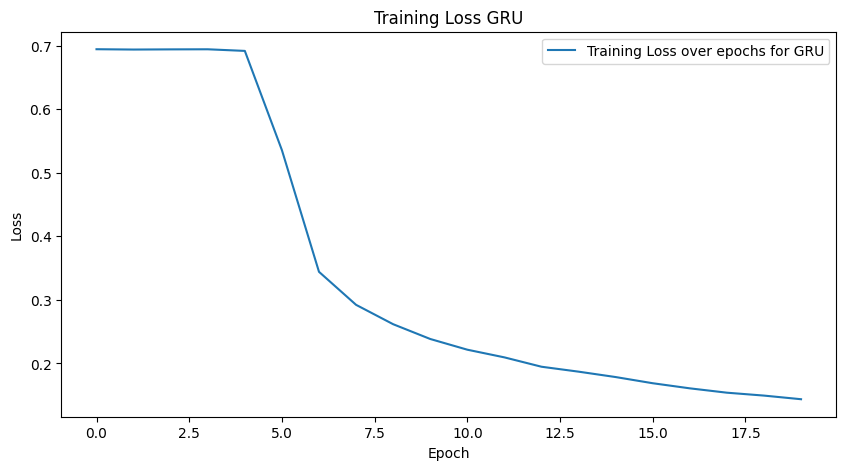

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_,GRU_train_loss, label = 'Training Loss over epochs for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss GRU')
plt.legend()
plt.show()

# Evaluating GRU model

In [108]:
modelGRU.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = modelGRU(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    test_accuracy_GRU = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy_GRU:.2f}%")
model_path = r'C:\Users\Raj\Desktop\Deep Learning\Assignment 2\part3\models\rkhatik_assignment2_part3GRU.pickle'
with open(model_path, 'wb') as file:
    pickle.dump(modelGRU, file)
print("Model saved successfully.")

Test Accuracy: 91.24%
Model saved successfully.


# plot for loss comparison

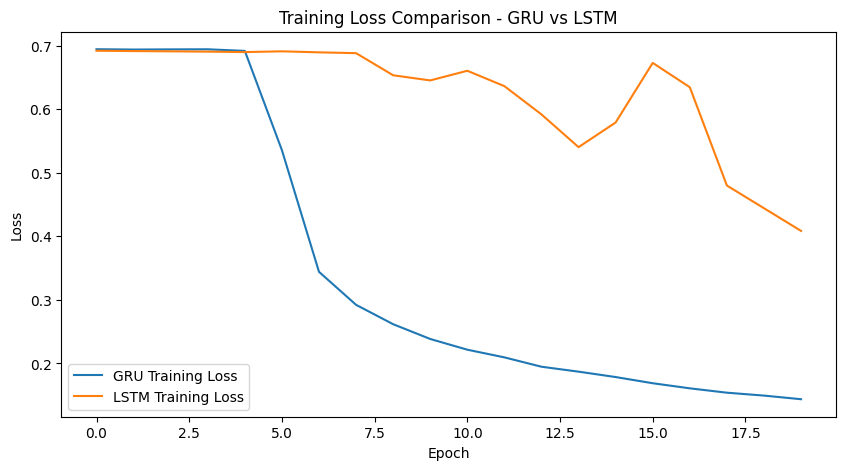

In [104]:

plt.figure(figsize=(10, 5))
plt.plot(epochs_, GRU_train_loss, label='GRU Training Loss')
plt.plot(epochs_, LSTM_train_loss, label='LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison - GRU vs LSTM')
plt.legend()
plt.show()

# Accuracy comparison

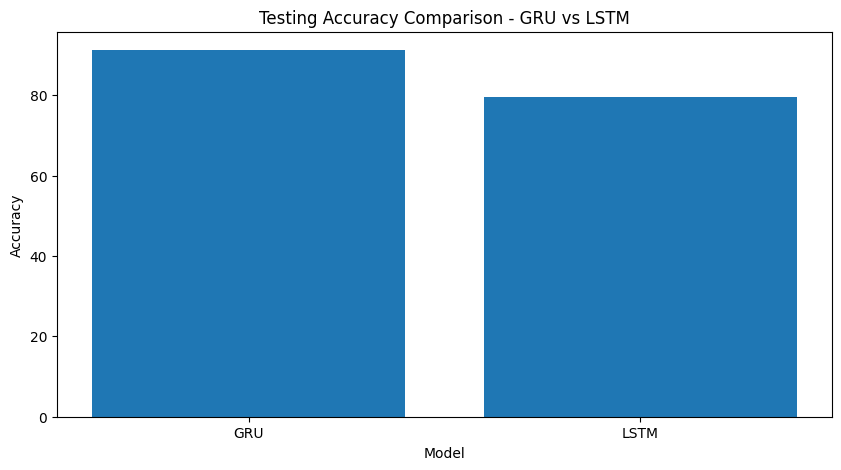

In [112]:
plt.figure(figsize=(10, 5))
plt.bar(['GRU', 'LSTM'], [test_accuracy_GRU, test_accuracy_LSTM])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy Comparison - GRU vs LSTM')
plt.show()